# Sentiment Analysis with Deep Learning using BERT

### Prerequisites

- Intermediate-level knowledge of Python 3 (NumPy and Pandas preferably, but not required)
- Exposure to PyTorch usage
- Basic understanding of Deep Learning and Language Models (BERT specifically)

### Project Outline

**Task 1**: Introduction (this section)

**Task 2**: Exploratory Data Analysis and Preprocessing

**Task 3**: Training/Validation Split

**Task 4**: Loading Tokenizer and Encoding our Data

**Task 5**: Setting up BERT Pretrained Model

**Task 6**: Creating Data Loaders

**Task 7**: Setting Up Optimizer and Scheduler

**Task 8**: Defining our Performance Metrics

**Task 9**: Creating our Training Loop

**Task 10**: Loading and Evaluating our Model

## Task 1: Introduction

### What is BERT

BERT is a large-scale transformer-based Language Model that can be finetuned for a variety of tasks.

For more information, the original paper can be found [here](https://arxiv.org/abs/1810.04805). 

[HuggingFace documentation](https://huggingface.co/transformers/model_doc/bert.html)

[Bert documentation](https://characters.fandom.com/wiki/Bert_(Sesame_Street) ;)

<img src="Images/BERT_diagrams.pdf" width="1000">

## Task 2: Exploratory Data Analysis and Preprocessing

We will use the SMILE Twitter dataset.

_Wang, Bo; Tsakalidis, Adam; Liakata, Maria; Zubiaga, Arkaitz; Procter, Rob; Jensen, Eric (2016): SMILE Twitter Emotion dataset. figshare. Dataset. https://doi.org/10.6084/m9.figshare.3187909.v2_

In [1]:
import torch
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('Data/smile-annotations-final.csv', 
                 names = ['id', 'text', 'category'])
df.set_index('id', inplace=True)

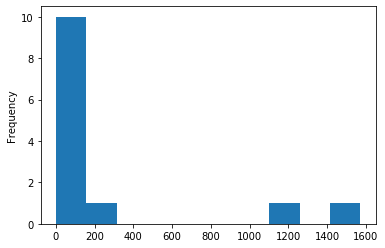

In [11]:
df.category.value_counts().plot(kind='hist')

In [13]:
index_tweet = df[(df['category'] == 'nocode')].index
df.drop(index_tweet, inplace=True)
df = df[~df.category.str.contains('\|')]
df.category.value_counts()

happy           1137
not-relevant     214
angry             57
surprise          35
sad               32
disgust            6
Name: category, dtype: int64

In [15]:
label_dict = {
    'happy': 0,
    'not-relevant': 1,
    'angry': 2,
    'surprise': 3,
    'sad': 4,
    'disgust': 5
}

In [17]:
type(label_dict)

dict

In [20]:
df['label'] = df.category.replace(label_dict)

/home/rhyme/envs/project_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,text,category,label
id,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0
614877582664835073,@Sofabsports thank you for following me back. ...,happy,0
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0


## Task 3: Training/Validation Split

In [22]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_val, y_train, y_val = train_test_split(
    df.index.values,
    df.label.values,
    test_size = 0.15,
    random_state = 17,
    stratify = df.label.values
)

In [29]:
df['data_type'] = ['not_set']*df.shape[0]

In [30]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [31]:
df.groupby(['category', 'label', 'data_type']).count()

text
category     label data_type      
angry        2     train        48
                   val           9
disgust      5     train         5
                   val           1
happy        0     train       966
                   val         171
not-relevant 1     train       182
                   val          32
sad          4     train        27
                   val           5
surprise     3     train        30
                   val           5

## Task 4: Loading Tokenizer and Encoding our Data

In [32]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [33]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
)

In [34]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values,
    add_special_tokens=True,
    return_attention_masks=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt')

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].text.values,
    add_special_tokens=True,
    return_attention_masks=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt')

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type == 'train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type == 'val'].label.values)

In [38]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [43]:
dataset_val[9]

(tensor([  101,  1012,  1030,  2120, 22263,  7301, 26663,  3980,  2006, 12026,
          9883,  2363,  2013,  5806,  1012,  2053, 20096,  1012,  1001,  2396,
         28556, 16770,  1024,  1013,  1013,  1056,  1012,  2522,  1013,  2358,
         27421, 14194,  2487, 16425,  2480,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [42]:
len(dataset_val)

223

## Task 5: Setting up BERT Pretrained Model

In [45]:
from transformers import BertForSequenceClassification

In [46]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = len(label_dict),
    output_attentions = False,
    output_hidden_states = False
)

## Task 6: Creating Data Loaders

In [47]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [61]:
batch_size = 4
dataloaders_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloaders_val = DataLoader(
    dataset=dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=32
)

## Task 7: Setting Up Optimizer and Scheduler

In [50]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [52]:
optimizer = AdamW(
    model.parameters(),
    lr=1e-5,
    eps=1e-8
)

In [60]:
epochs = 10

scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloaders_train)*epoch
)

## Task 8: Defining our Performance Metrics

Accuracy metric approach originally used in accuracy function in [this tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification).

In [54]:
import numpy as np

In [55]:
from sklearn.metrics import f1_score

In [1]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [56]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat == label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds == label])}/{len(y_true)}')

## Task 9: Creating our Training Loop

Approach adapted from an older version of HuggingFace's `run_glue.py` script. Accessible [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128).

In [57]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cpu


In [59]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals


In [63]:
for epoch in tqdm(range(1, epochs+1)):
    model.train()
    
    loss_train_total = 0
    progress_bar = tqdm(dataloaders_train, desc = 'Epoch {:1d}'.format(epoch),
                       leave = False,
                       disable = False)
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training loss': '{:.3f}'.format(loss.item()/len(batch))})
    
    torch.save(model.state_dict(), f'Models/BERT_ft_epoch{epoch}.model')
    
    tqdm.write('\nEpoch{epoch}')
    loss_train_avg = loss_train_total/len(dataloaders_train)
    tqdm.write(f'Training Loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloaders_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation Loss: {val_loss}')
    tqdm.write(f'F1 Score(weighted): {val_f1}')

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


KeyboardInterrupt: 

## Task 10: Loading and Evaluating our Model

In [64]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

In [65]:
model.load_state_dict(torch.load('Models/finetuned_bert_epoch_1_gpu_trained.model',
                                map_location=torch.device('cpu')))

<All keys matched successfully>

In [66]:
_,predictions, true_vals = evaluate(dataloaders_val)

In [67]:
accuracy_per_class(predictions, true_vals)

Class: happy
Accuracy: 163/171
Class: not-relevant
Accuracy: 20/32
Class: angry
Accuracy: 7/9
Class: surprise
Accuracy: 0/5
Class: sad
Accuracy: 5/5
Class: disgust
Accuracy: 0/1
